In [1]:
import os
import math
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
plt.rcParams['font.family'] = 'AppleGothic'

In [6]:
# 파일시스템으로부터 데이터 파일 읽기
primitive_df = pd.read_csv(os.path.relpath('./train_data.csv'), index_col='id')

In [10]:
train_df = primitive_df.copy()

In [11]:
# 모든 숫자형 컬럼에 대해서 0 -> NaN으로 변경
def replaceZeroToNull(x):
    if x == 0:
        return None
    return x

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.to_list()

for col in numeric_cols:
    train_df[col] = train_df[col].apply(lambda x: replaceZeroToNull(x))

# contactDate컬럼 타입 변경 (string -> Date)
train_df['contactDate'] = train_df['contactDate'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [12]:
# brand열: 건설회사
def cleanBrand(raw):
    if pd.isnull(raw):
        return '기타'
    
    raw = raw.split(',')[0]
    raw = raw.split('외')[0]
    raw = raw.replace('(주)', '')
    raw = raw.replace('쭈', '')
    raw = raw.replace('(', '')
    raw = raw.replace(')', '')
    raw = raw.replace('', '')
    raw = raw.replace('M&C', '')
    raw = raw.replace('㈜', '')
    raw = raw.replace('주식회사', '')
    raw = raw.replace('주식회서', '')
    raw = raw.replace('건설', '')
    raw = raw.replace('종합', '')
    raw = raw.replace('종합', '')
    raw = raw.strip()
    raw = raw.split(' ')[0]

    return raw

train_df['brand'] = train_df['constructionCompanyName'].apply(cleanBrand)

In [13]:
# 데이터상에서 100회 이하로 언급되는 건설회사 -> 기타로 취급
brands = train_df['brand'].value_counts() > 100

noNamedBrands = []
for brand, isNamed in zip(brands.index, brands.values):
    if not isNamed:
        noNamedBrands.append(brand)
        
def extendEtc(name):
    if name in noNamedBrands:
        return '기타'
    return name

train_df['brand'] = train_df['brand'].apply(extendEtc)

train_df.drop('constructionCompanyName', axis=1, inplace=True)

In [8]:
# contactDay열: 2000년 1월 1일을 기준으로 계약일까지의 일 수
critia_date = datetime.datetime(2000, 1, 1)
def date2Mon(date):
    return (date - critia_date).days

train_df['contactDay'] = train_df['contactDate'].apply(date2Mon)
train_df.drop('contactDate', axis=1, inplace=True)

In [9]:
# volume열: 단지별 역대 거래량
volume_dict = train_df.groupby('complexName').count()['price'].to_dict()

train_df['volume'] = train_df['complexName'].apply(lambda x: volume_dict[x])

In [10]:
# floorRate열: 매물의 층과 전체 아파트 층과의 비율 
train_df['floorRate'] = train_df['floor'] / ((train_df['highFloor'] + train_df['lowFloor'])*0.8)

In [11]:
# 숫자형 컬럼
numeric_features = train_df.select_dtypes(include=[np.number])
numeric_features.dtypes

exclusiveArea               float64
price                         int64
floor                         int64
constructYear                 int64
supplyArea                  float64
householdCountByPyeong      float64
exclusiveRate               float64
roomCnt                     float64
bathroomCnt                 float64
latitude                    float64
longitude                   float64
totalHouseholdCount         float64
totalLeaseHouseholdCount    float64
highFloor                   float64
lowFloor                    float64
totalDongCount              float64
maxSupplyArea               float64
minSupplyArea               float64
batlRatio                   float64
btlRatio                    float64
parkingCountByHousehold     float64
distHangang                 float64
distStation                 float64
distHospital                float64
contactDay                    int64
volume                        int64
floorRate                   float64
dtype: object

In [12]:
# 객체형 컬럼
categorical_features = train_df.select_dtypes(include=[np.object])
categorical_features.dtypes

detailAddress         object
complexName           object
roadAddress           object
realEstateTypeCode    object
entranceType          object
heatMethodTypeCode    object
heatFuelTypeCode      object
address               object
nameStation           object
nameHospital          object
brand                 object
dtype: object

Price Skew:  3.1968312183707543
Price Kurtosis: 19.110902


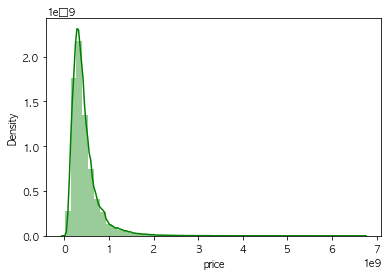

In [13]:
# 종속변수 편향도 & 첨도
print("Price Skew: ", train_df.price.skew())
print("Price Kurtosis: %f" % train_df.price.kurt())

sns.distplot(train_df.price, color='green')
plt.show()

Price Skew:  0.20894655536409165
Price Kurtosis: 0.485146


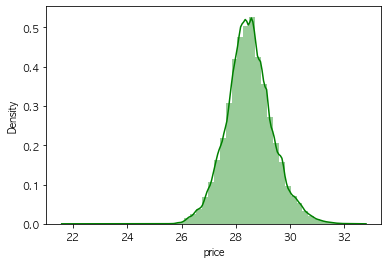

In [14]:
log_price = np.log2(train_df.price)

print("Price Skew: ", log_price.skew())
print("Price Kurtosis: %f" % log_price.kurt())

sns.distplot(log_price, color='green')
plt.show()

In [15]:
# 종속변수 - 독립변수 상관관계
corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False))

price                       1.000000
supplyArea                  0.658616
exclusiveArea               0.652691
maxSupplyArea               0.570340
roomCnt                     0.501385
parkingCountByHousehold     0.452651
minSupplyArea               0.436999
bathroomCnt                 0.412517
highFloor                   0.297713
contactDay                  0.288454
exclusiveRate               0.284920
totalDongCount              0.211858
lowFloor                    0.183260
floor                       0.162933
totalHouseholdCount         0.119233
constructYear               0.104106
longitude                   0.085150
householdCountByPyeong      0.011781
floorRate                   0.010887
batlRatio                  -0.006500
distHospital               -0.072644
volume                     -0.082593
btlRatio                   -0.100616
distStation                -0.105543
distHangang                -0.131017
totalLeaseHouseholdCount   -0.178921
latitude                   -0.306248
N

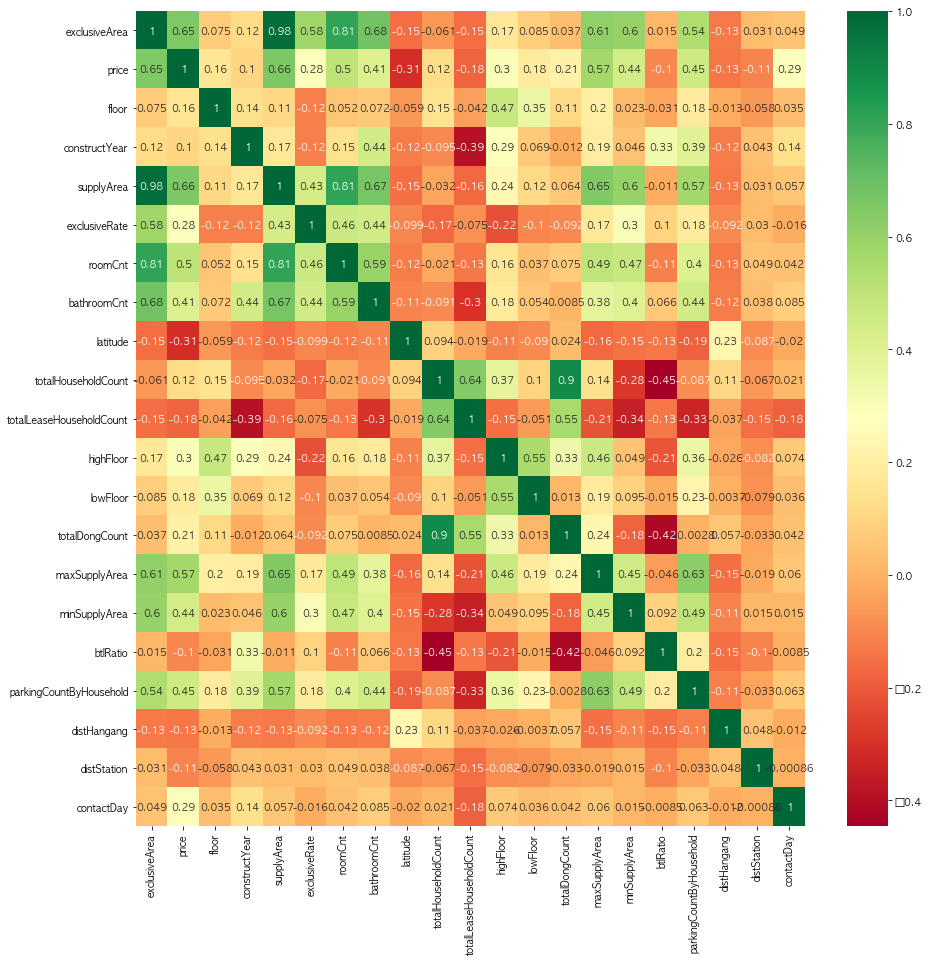

In [16]:
# 히트맵 시각화
corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat['price']) > 0.1]
plt.figure(figsize=(15, 15))
g = sns.heatmap(train_df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

# supplyArea와 exclusiveArea의 상관계수가 0.98으로 상관관계가 매우 높다(매우 당연하다...!)
# totalDongCount와 totalHouseholdCount의 상관계수가 0.9로 높다

In [17]:
# 상관계수가 높은 컬럼(totalHouseholdCount, exclusiveArea) 삭제
train_df.drop(['totalHouseholdCount', 'exclusiveArea'], axis=1, inplace=True)

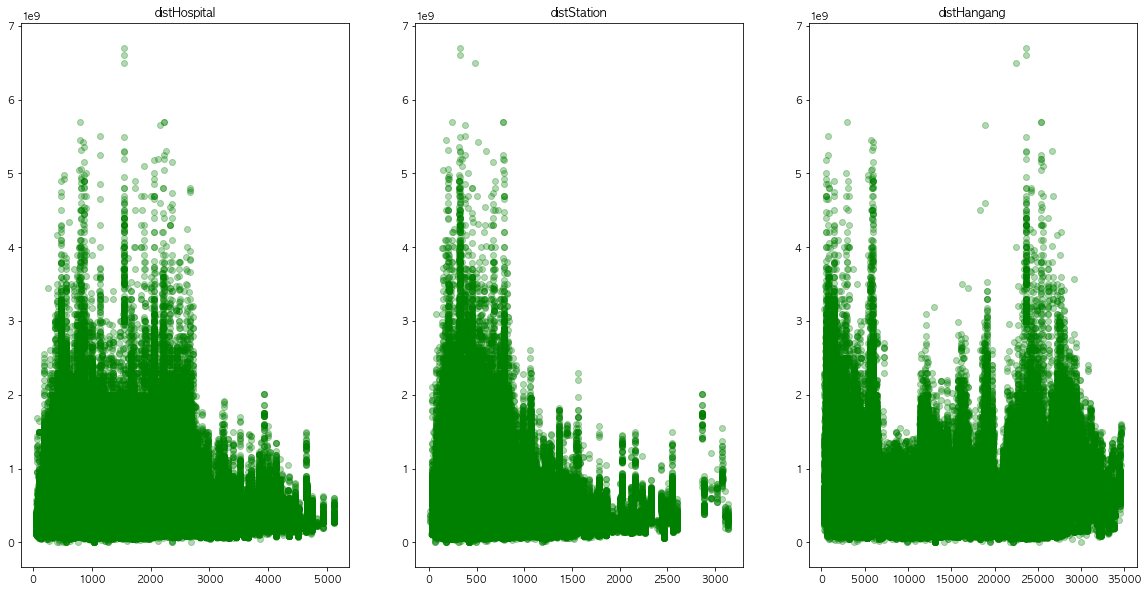

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
axes = np.ravel(axes)
col_name = ['distHospital', 'distStation', 'distHangang']
for i, c in zip(range(len(col_name)), col_name):
    axes[i].scatter(train_df[c], train_df['price'], alpha=0.3, c='green')
    axes[i].set_title(c)

plt.show()

In [19]:
# 컬럼별 결측치 비율
train_df.isnull().sum()/train_df.shape[0]*100

detailAddress                0.000000
complexName                  0.000000
price                        0.000000
floor                        0.000000
constructYear                0.000000
roadAddress                  0.000000
supplyArea                   0.000000
householdCountByPyeong       0.001893
realEstateTypeCode           0.000000
exclusiveRate                0.000000
entranceType                 0.000000
roomCnt                      0.021202
bathroomCnt                  0.021202
latitude                     0.000000
longitude                    0.000000
totalLeaseHouseholdCount    92.379860
highFloor                    0.000000
lowFloor                     0.000000
totalDongCount               0.001262
maxSupplyArea                0.000000
minSupplyArea                0.009844
batlRatio                    4.918051
btlRatio                    10.493610
parkingCountByHousehold      4.659718
heatMethodTypeCode           0.042908
heatFuelTypeCode             0.040384
address     

In [20]:
# 결측치가 너무 많은 totalLeaseHouseholdCount, btlRatio, parkingCountByHousehold, batlRatio열 삭제
train_df.drop(['totalLeaseHouseholdCount', 'btlRatio', 'parkingCountByHousehold', 'batlRatio'], axis=1, inplace=True)

In [21]:
# 레코드 중 NaN이 있는 레코드 개수(False)
(train_df.isnull().sum(1) == 0).value_counts()

True     791456
False       931
dtype: int64

In [22]:
# 결측값이 있는 행 삭제
train_df.dropna(inplace=True)

In [23]:
# 컬럼별 결측값 개수
train_df.isnull().sum()

# 결측값이 모두 제거됨

detailAddress             0
complexName               0
price                     0
floor                     0
constructYear             0
roadAddress               0
supplyArea                0
householdCountByPyeong    0
realEstateTypeCode        0
exclusiveRate             0
entranceType              0
roomCnt                   0
bathroomCnt               0
latitude                  0
longitude                 0
highFloor                 0
lowFloor                  0
totalDongCount            0
maxSupplyArea             0
minSupplyArea             0
heatMethodTypeCode        0
heatFuelTypeCode          0
address                   0
distHangang               0
distStation               0
nameStation               0
distHospital              0
nameHospital              0
brand                     0
contactDay                0
volume                    0
floorRate                 0
dtype: int64

In [24]:
# 데이터 처리 후 상관관계
numeric_features = train_df.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False))

price                     1.000000
supplyArea                0.658869
maxSupplyArea             0.570246
roomCnt                   0.501339
minSupplyArea             0.437300
bathroomCnt               0.412446
highFloor                 0.297595
contactDay                0.288407
exclusiveRate             0.284382
totalDongCount            0.211806
lowFloor                  0.183092
floor                     0.162881
constructYear             0.104326
longitude                 0.085169
householdCountByPyeong    0.011695
floorRate                 0.010956
distHospital             -0.072555
volume                   -0.082662
distStation              -0.105865
distHangang              -0.130673
latitude                 -0.306036
Name: price, dtype: float64


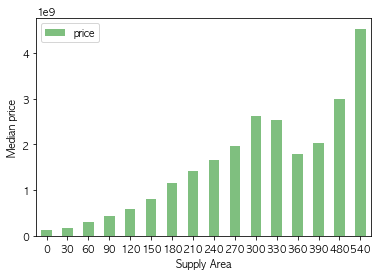

In [25]:
train_df['supplyAreaRange'] = train_df['supplyArea'].apply(lambda x: int(x/30)*30)
quality_pivot = train_df.pivot_table(index='supplyAreaRange', values='price', aggfunc=np.median)
quality_pivot.plot(kind='bar', color='green', alpha = 0.5)
plt.xlabel('Supply Area')
plt.ylabel('Median price')
plt.xticks(rotation=0)
plt.show()

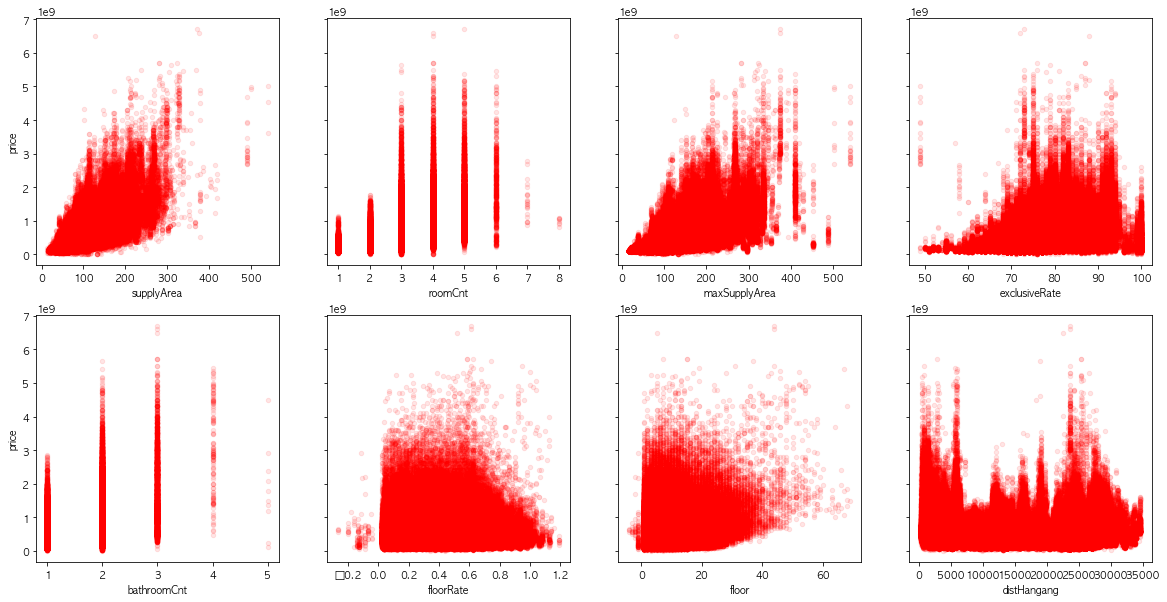

In [26]:
# 주요 컬럼 시각화
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axes = np.ravel(axes)
col_name = ['supplyArea','roomCnt','maxSupplyArea','exclusiveRate', 'bathroomCnt', 'floorRate', 'floor', 'distHangang']
for i, c in zip(range(len(col_name)), col_name):
    train_df.plot.scatter(ax=axes[i], x=c, y='price', sharey=True, colorbar=False, color='red', alpha = 0.1)   

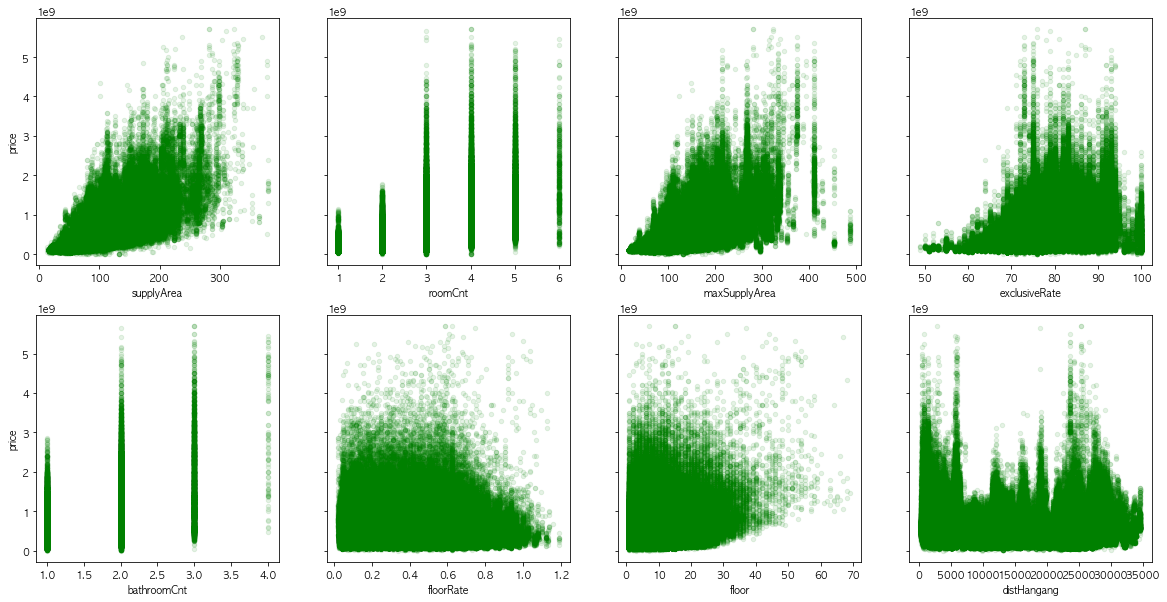

In [27]:
# 이상치 제거
train_df = train_df[train_df['price'] < 6000000000]
train_df = train_df[train_df['supplyArea'] < 450]
train_df = train_df[train_df['roomCnt'] < 7]
train_df = train_df[train_df['maxSupplyArea'] < 500]
train_df = train_df[(train_df['exclusiveRate']>60) | (train_df['price']<1000000000)]
train_df = train_df[train_df['bathroomCnt'] < 5]
train_df = train_df[train_df['floorRate'] >= 0]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axes = np.ravel(axes)
for i, c in zip(range(len(col_name)), col_name):
    train_df.plot.scatter(ax=axes[i], x=c, y='price', sharey=True, colorbar=False, color='green', alpha = 0.1)   

In [28]:
# 카테고리형 컬럼 
categoricals = train_df.select_dtypes(exclude=[np.number])

for c in categoricals.columns:
    print('{:<14}'.format(c), train_df[c].unique())

detailAddress  ['713' '655-2' '658-1' ... '51-11' '1546' '1005']
complexName    ['브라운스톤방학아파트' '개포2차현대아파트(220)' '개포6차우성아파트1동~8동' ... '하니맨션' '(1546-0)'
 '(578-5)201호 미공시']
roadAddress    ['도봉로146길 36' '언주로 103' '언주로 3' ... '난계로15길 36-6' '난계로13길 36' '망우로 297']
realEstateTypeCode ['A01' 'A03']
entranceType   ['계단식' '복도식' '복합식']
heatMethodTypeCode ['HT001' 'HT002' 'HT005' 'HT003']
heatFuelTypeCode ['HF001' 'HF002' 'HF004' 'HF007' 'HF003']
address        ['서울시 도봉구 방학동' '서울시 강남구 개포동' '서울시 강남구 논현동' '서울시 강남구 대치동' '서울시 강남구 도곡동'
 '서울시 강남구 삼성동' '서울시 강남구 세곡동' '서울시 강남구 수서동' '서울시 강남구 신사동' '서울시 강남구 압구정동'
 '서울시 강남구 역삼동' '서울시 강남구 일원동' '서울시 강남구 자곡동' '서울시 강남구 청담동' '서울시 강동구 강일동'
 '서울시 강동구 고덕동' '서울시 강동구 길동' '서울시 강동구 둔촌동' '서울시 강동구 명일동' '서울시 강동구 상일동'
 '서울시 강동구 성내동' '서울시 강동구 암사동' '서울시 강동구 천호동' '서울시 강북구 미아동' '서울시 강북구 번동'
 '서울시 강북구 수유동' '서울시 강북구 우이동' '서울시 강서구 가양동' '서울시 강서구 공항동' '서울시 강서구 내발산동'
 '서울시 강서구 등촌동' '서울시 강서구 마곡동' '서울시 강서구 방화동' '서울시 강서구 염창동' '서울시 강서구 화곡동'
 '서울시 관악구 남현동' '서울시 관악구 봉천동' '서울시 관악구 신림동' '서울시 광진

In [29]:
# 학습에 쓸모없는 열 삭제
train_df.drop(['detailAddress', 'complexName', 'roadAddress', 'nameHospital', 'nameStation'], axis=1, inplace=True)

In [30]:
# 카테고리형 컬럼 원핫인코딩
columns = train_df.select_dtypes(exclude=[np.number]).columns

for c in columns:
    oh_df = pd.get_dummies(train_df[c])
    train_df = pd.concat([train_df, oh_df], axis=1)
    train_df.drop(c, axis=1)

train_df.shape

(791248, 784)

In [31]:
# 원핫인코딩한 열 삭제
train_df.drop(columns, axis=1, inplace=True)

In [3]:
X = pd.read_csv("X_train.csv", index_col="id")
raw_y = pd.read_csv("y_train.csv", index_col="id")

In [4]:
y = np.log2(raw_y)

In [ ]:
# 중요도가 0.00005 이상인 열만 추출
importantFeatures = df_fi[df_fi['importances'] > 0.0001]['columns'].to_list()

train_df_fi = train_df[importantFeatures]

print(len(importantFeatures))

In [46]:
# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [49]:
# RandomForest
random_forest_regressor = RandomForestRegressor(n_estimators=150, n_jobs=-1)
random_forest_regressor = random_forest_regressor.fit(X_train, y_train)


NameError: name 'y_pred_rf' is not defined

In [50]:
y_pred_rf = random_forest_regressor.predict(X_test)
print('The accuracy of the Random Forset is', r2_score(np.exp2(y_test),np.exp2(y_pred_rf)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_rf))**0.5)
print('\n')

The accuracy of the Random Forset is 0.9828529724763779
RMSE is:  46834681.69233127




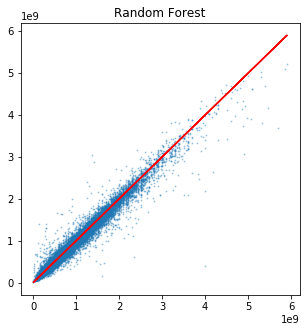

In [51]:
# Random Forest Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_rf), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('Random Forest')
plt.show()

In [48]:
# DecisionTree
decision_tree_regressor = DecisionTreeRegressor(max_depth=24, random_state=0)
decision_tree_regressor = decision_tree_regressor.fit(X_train, y_train)
y_pred_dt = decision_tree_regressor.predict(X_test)

print('The accuracy of the Decision Tree is',r2_score(np.exp2(y_test),np.exp2(y_pred_dt)))
print('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_dt))**0.5)
print('\n')


The accuracy of the Decision Tree is 0.970554620164555
RMSE is:  61373618.71316391




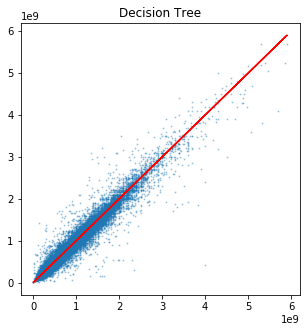

In [40]:
# Decision Tree Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_dt), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('Decision Tree')
plt.show()

In [41]:
# XGBoost
xgboost_regressor = XGBRegressor(max_depth=13)
xgboost_regressor = xgboost_regressor.fit(X_train, y_train)

y_pred_xgb = xgboost_regressor.predict(X_test)
print('The accuracy of the XGBoost is', r2_score(np.exp2(y_test),np.exp2(y_pred_xgb)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_xgb))**0.5)
print('\n')

[10:47:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The accuracy of the XGBoost is 0.98137154123719
RMSE is:  48815935.09085284




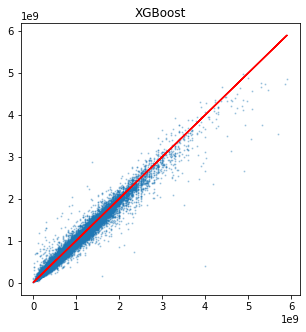

In [42]:
# XGBoost Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_xgb), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('XGBoost')
plt.show()

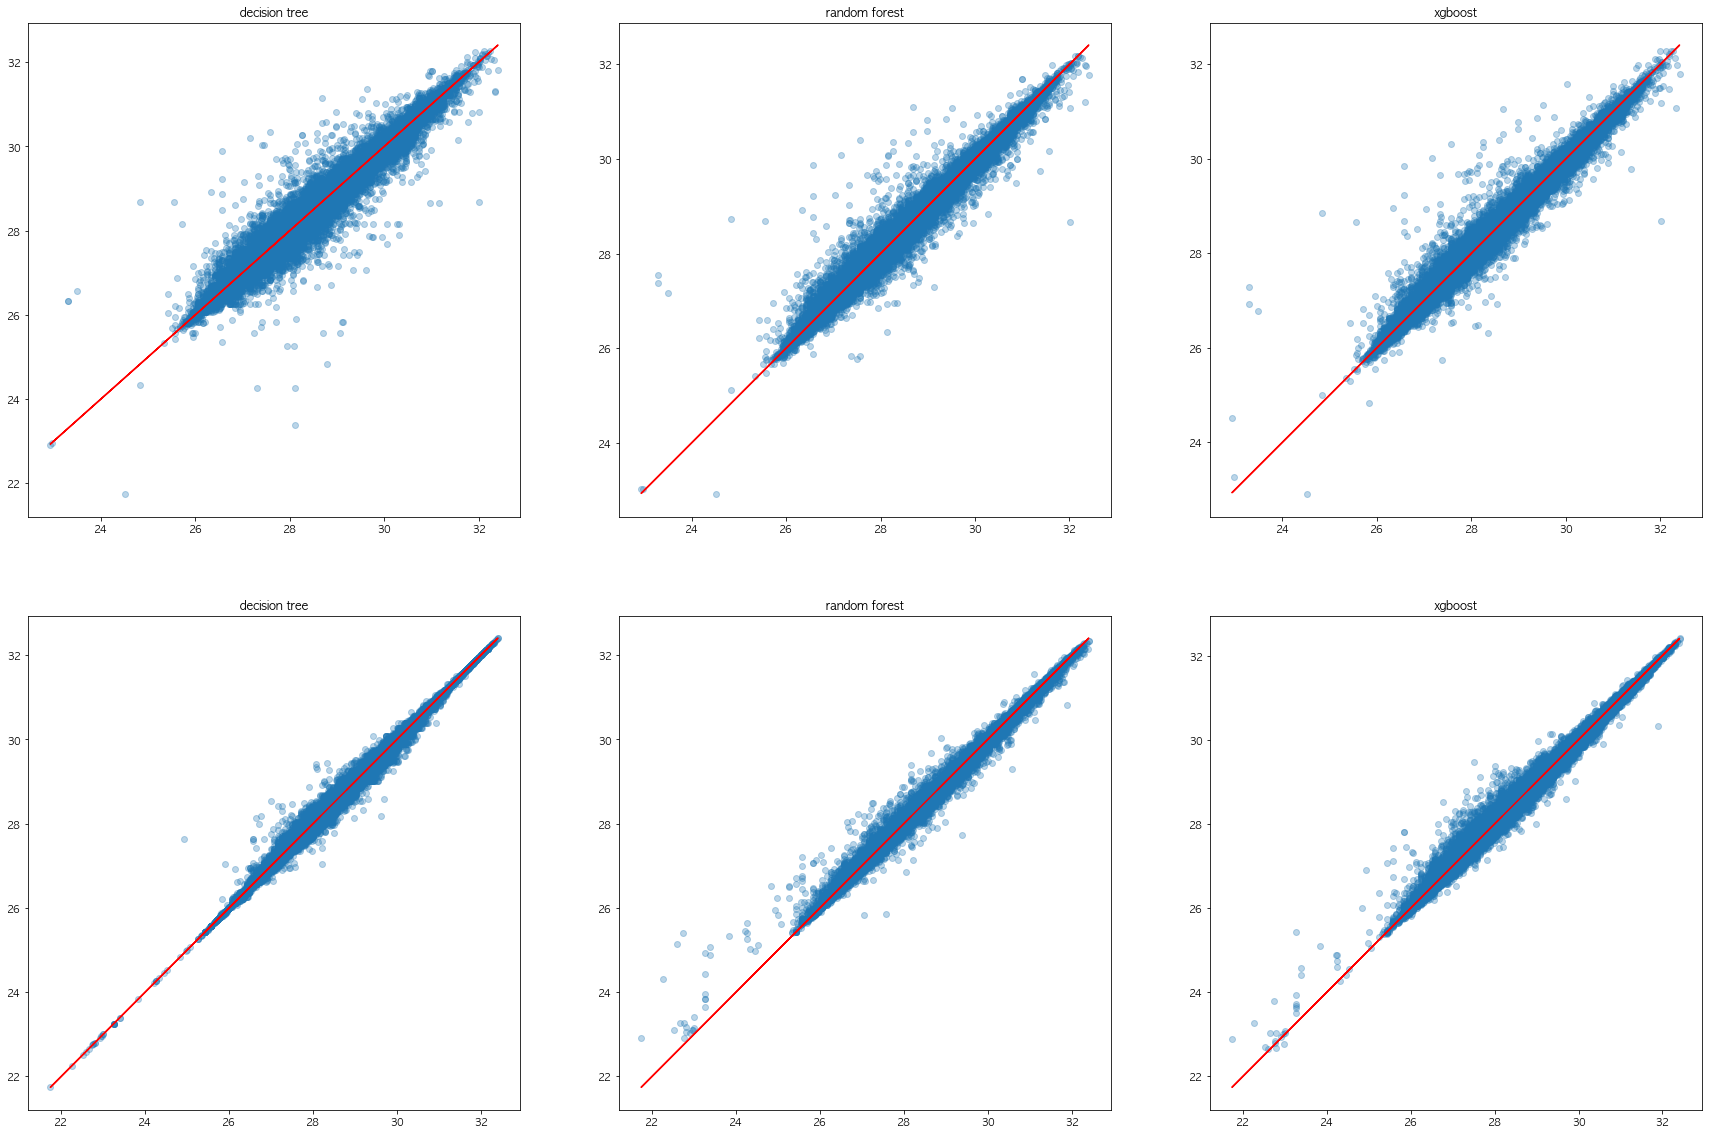

In [70]:
# 모델 학습 결과 시각화
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(30, 20))
axes = np.ravel(axes)
models = [decision_tree_regressor, random_forest_regressor, xgboost_regressor]
model_types = ['decision tree', 'random forest', 'xgboost']
for i, model in zip(range(3), models):
    y_pred = model.predict(X_test)
    axes[i].scatter(y_test,y_pred, alpha=0.3)
    axes[i].plot(y_test,y_test,'r')
    axes[i].set_title(model_types[i])
    
for i, model in zip(range(3, 6), models):
    y_pred_train = model.predict(X_train)
    axes[i].scatter(y_train,y_pred_train, alpha=0.3)
    axes[i].plot(y_train,y_train,'r')
    axes[i].set_title(model_types[i-3])
    
plt.show()

In [91]:
y_test_orig.values

array([9.45920873e+11, 2.36072356e+12, 2.52503847e+12, ...,
       1.14998769e+12, 6.86376618e+12, 1.44287355e+12])

In [36]:
error_ratio = abs(y_pred_rf - y_test.values) / y_test.values * 100

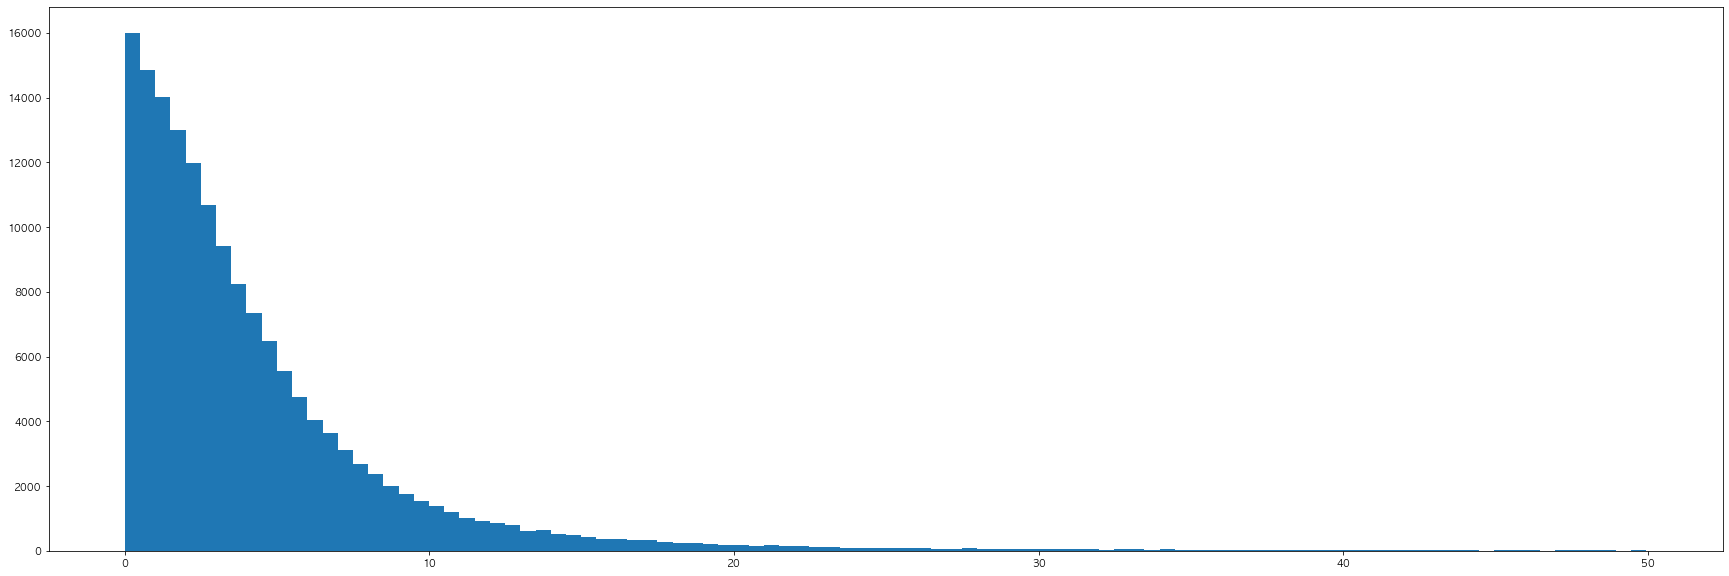

143511


In [38]:
plt.figure(figsize=(30, 10))
plt.hist(error_ratio[error_ratio < 50], bins=100)
plt.show()

print(len(error_ratio[error_ratio < 10]))

In [6]:
# Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [12]:
# 피처 스케일링
minmaxscaler = MinMaxScaler()
X_scale = minmaxscaler.fit_transform(X)
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size = 0.2, random_state = 1)

In [13]:
X_train

array([[0.15439517, 0.        , 0.66666667, ..., 0.20689794, 0.1786918 ,
        0.4267905 ],
       [0.11093397, 0.01089547, 0.23529412, ..., 0.11053988, 0.06460762,
        0.30597003],
       [0.06472579, 0.00068097, 0.60784314, ..., 0.2520013 , 0.01947022,
        0.18164638],
       ...,
       [0.0814039 , 0.16172966, 0.49019608, ..., 0.00530279, 0.13698543,
        0.19262593],
       [0.15071618, 0.04834866, 0.60784314, ..., 0.18327108, 0.22710994,
        0.2179796 ],
       [0.25100559, 0.04664624, 0.47058824, ..., 0.39825167, 0.18592478,
        0.29158011]])

The accuracy of the Nerual Network is 0.6924518441931307
RMSE is:  198348862.41763937


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


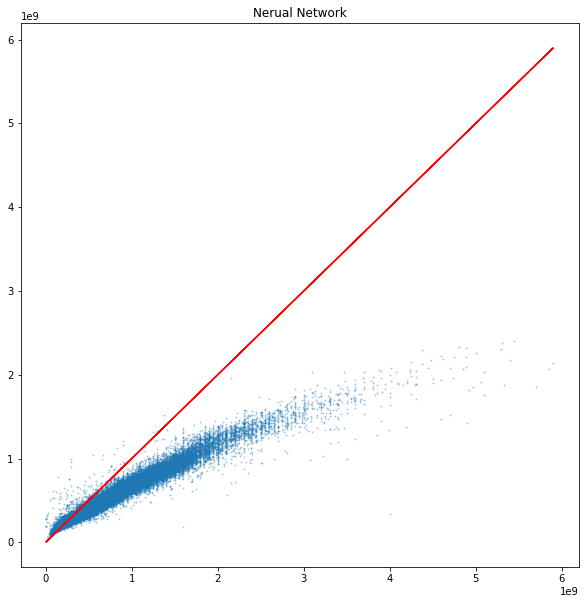

In [17]:
y_pred_nn = model.predict(X_test)
print('The accuracy of the Nerual Network is', r2_score(np.exp2(y_test),np.exp2(y_pred_nn)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_nn))**0.5)

fig = plt.figure(figsize=(10,10))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_nn), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('Nerual Network')
plt.show()

In [22]:
from tensorflow.keras.layers import BatchNormalization
# DNN 1 layer 구조
dnn_layer_1 = Sequential()
dnn_layer_1.add(Dense(66,activation='relu'))
dnn_layer_1.add(Dense(256,activation='relu'))
dnn_layer_1.add(BatchNormalization())
dnn_layer_1.add(Dense(1))

dnn_layer_1.compile(optimizer='Adam',loss='mse')

In [23]:
# DNN 1 layer 학습
dnn_layer_1.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=256,epochs=50)
dnn_layer_1.summary()

Train on 733245 samples, validate on 183312 samples
Epoch 1/50
733245/733245 [==============================] - 10s 14us/sample - loss: 34.8786 - val_loss: 0.0909
Epoch 2/50
733245/733245 [==============================] - 10s 13us/sample - loss: 0.0741 - val_loss: 0.1025
Epoch 3/50
733245/733245 [==============================] - 10s 13us/sample - loss: 0.0591 - val_loss: 0.0746
Epoch 4/50
733245/733245 [==============================] - 10s 13us/sample - loss: 0.0517 - val_loss: 0.0837
Epoch 5/50
733245/733245 [==============================] - 10s 13us/sample - loss: 0.0473 - val_loss: 0.0547
Epoch 6/50
733245/733245 [==============================] - 10s 13us/sample - loss: 0.0450 - val_loss: 0.0420
Epoch 7/50
733245/733245 [==============================] - 10s 13us/sample - loss: 0.0427 - val_loss: 0.0478
Epoch 8/50
733245/733245 [==============================] - 10s 13us/sample - loss: 0.0414 - val_loss: 0.0447
Epoch 9/50
733245/733245 [==============================] - 10s 13u

The accuracy of the Nerual Network layer 1 is 0.9524779858993991
RMSE is:  77968749.68242775


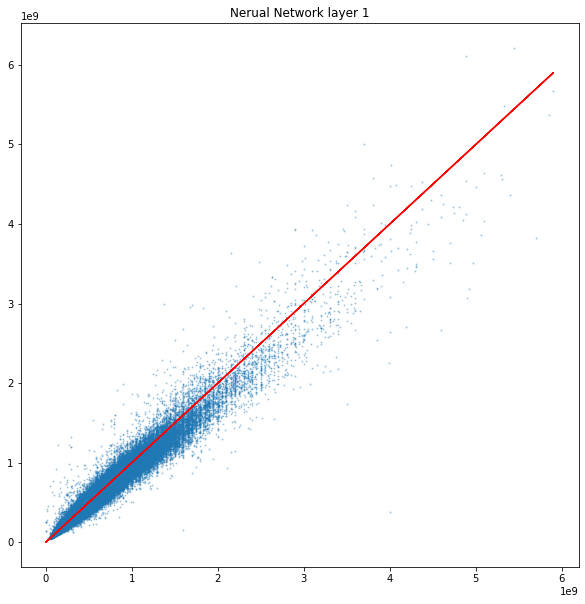

In [27]:
y_pred_nn_1 = dnn_layer_1.predict(X_test)
print('The accuracy of the Nerual Network layer 1 is', r2_score(np.exp2(y_test),np.exp2(y_pred_nn_1)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_nn_1))**0.5)

fig = plt.figure(figsize=(10,10))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_nn_1), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('Nerual Network layer 1')
plt.show()

In [18]:
# DNN 2 layer 구조

dnn_layer_2 = Sequential()
dnn_layer_2.add(Dense(66,activation='relu'))
dnn_layer_2.add(Dense(128,activation='relu'))
dnn_layer_2.add(Dropout(0.1))
dnn_layer_2.add(Dense(128,activation='relu'))
dnn_layer_2.add(Dropout(0.1))
dnn_layer_2.add(Dense(1))

dnn_layer_2.compile(optimizer='Adam',loss='mse')

In [20]:
# DNN 2 layer 학습
history_layer_2 = dnn_layer_2.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=256,epochs=50)
dnn_layer_2.summary()

Train on 733245 samples, validate on 183312 samples
Epoch 1/50
733245/733245 [==============================] - 8s 11us/sample - loss: 8.7783 - val_loss: 0.1608
Epoch 2/50
733245/733245 [==============================] - 8s 11us/sample - loss: 2.2948 - val_loss: 0.1390
Epoch 3/50
733245/733245 [==============================] - 8s 10us/sample - loss: 1.9679 - val_loss: 0.1784
Epoch 4/50
733245/733245 [==============================] - 7s 10us/sample - loss: 1.5600 - val_loss: 0.1620
Epoch 5/50
733245/733245 [==============================] - 8s 10us/sample - loss: 1.2767 - val_loss: 0.1183
Epoch 6/50
733245/733245 [==============================] - 7s 10us/sample - loss: 1.1478 - val_loss: 0.0932
Epoch 7/50
733245/733245 [==============================] - 7s 10us/sample - loss: 1.0432 - val_loss: 0.0762
Epoch 8/50
733245/733245 [==============================] - 7s 10us/sample - loss: 0.9577 - val_loss: 0.0776
Epoch 9/50
733245/733245 [==============================] - 7s 10us/sample -

The accuracy of the Nerual Network layer 2 is 0.967369237204034
RMSE is:  64608069.36981591


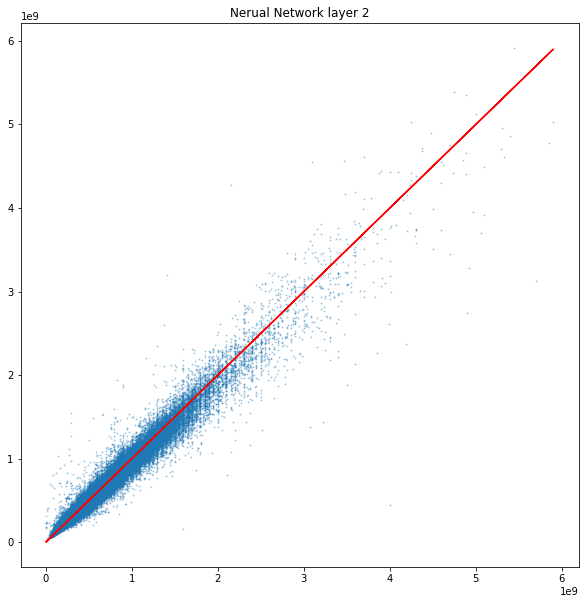

In [26]:
y_pred_nn_2 = dnn_layer_2.predict(X_test)
print('The accuracy of the Nerual Network layer 2 is', r2_score(np.exp2(y_test),np.exp2(y_pred_nn_2)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_nn_2))**0.5)

fig = plt.figure(figsize=(10,10))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_nn_2), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('Nerual Network layer 2')
plt.show()

In [28]:
# DNN 3 layer 구조
dnn_layer_3 = Sequential()
dnn_layer_3.add(Dense(66,activation='relu'))
dnn_layer_3.add(Dense(128,activation='relu'))
dnn_layer_3.add(BatchNormalization())
dnn_layer_3.add(Dense(128,activation='relu'))
dnn_layer_3.add(BatchNormalization())
dnn_layer_3.add(Dense(128,activation='relu'))
dnn_layer_3.add(BatchNormalization())
dnn_layer_3.add(Dense(1))

dnn_layer_3.compile(optimizer='Adam',loss='mse')

In [29]:
# DNN 3 layer 학습
dnn_layer_3.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=256,epochs=50)
dnn_layer_3.summary()

Train on 733245 samples, validate on 183312 samples
Epoch 1/50
733245/733245 [==============================] - 18s 24us/sample - loss: 48.2422 - val_loss: 0.1204
Epoch 2/50
733245/733245 [==============================] - 18s 24us/sample - loss: 0.0721 - val_loss: 0.0490
Epoch 3/50
733245/733245 [==============================] - 18s 24us/sample - loss: 0.0568 - val_loss: 0.0449
Epoch 4/50
733245/733245 [==============================] - 18s 24us/sample - loss: 0.0498 - val_loss: 0.0472
Epoch 5/50
733245/733245 [==============================] - 17s 24us/sample - loss: 0.0451 - val_loss: 0.0581
Epoch 6/50
733245/733245 [==============================] - 17s 24us/sample - loss: 0.0414 - val_loss: 0.0436
Epoch 7/50
733245/733245 [==============================] - 17s 24us/sample - loss: 0.0397 - val_loss: 0.0371
Epoch 8/50
733245/733245 [==============================] - 17s 24us/sample - loss: 0.0372 - val_loss: 0.0467
Epoch 9/50
733245/733245 [==============================] - 17s 24u

The accuracy of the Nerual Network layer 2 is 0.9731289979120321
RMSE is:  58629350.327789746


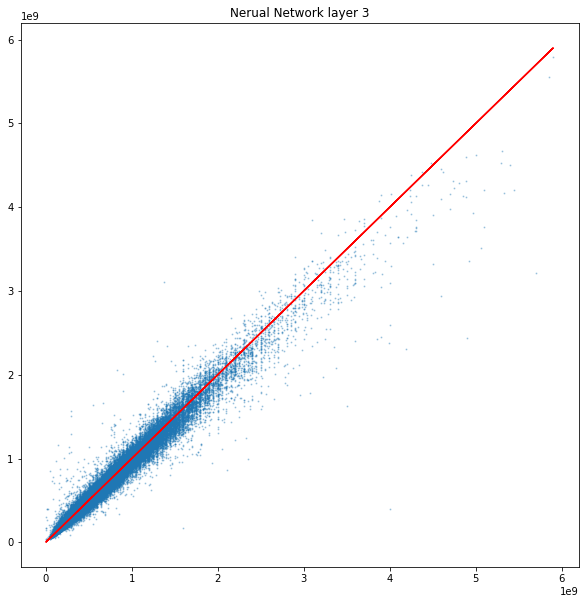

In [30]:
y_pred_nn_3 = dnn_layer_3.predict(X_test)
print('The accuracy of the Nerual Network layer 2 is', r2_score(np.exp2(y_test),np.exp2(y_pred_nn_3)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_nn_3))**0.5)

fig = plt.figure(figsize=(10,10))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_nn_3), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('Nerual Network layer 3')
plt.show()

In [31]:
# DNN 4 layer 구조
dnn_layer_4 = Sequential()
dnn_layer_4.add(Dense(66,activation='relu'))
dnn_layer_4.add(Dense(128,activation='relu'))
dnn_layer_4.add(BatchNormalization())
dnn_layer_4.add(Dense(128,activation='relu'))
dnn_layer_4.add(BatchNormalization())
dnn_layer_4.add(Dense(128,activation='relu'))
dnn_layer_4.add(BatchNormalization())
dnn_layer_4.add(Dense(128,activation='relu'))
dnn_layer_4.add(BatchNormalization())
dnn_layer_4.add(Dense(1))

dnn_layer_4.compile(optimizer='Adam',loss='mse')

In [32]:
# DNN 4 layer 학습
dnn_layer_4.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=256,epochs=50)
dnn_layer_4.summary()

Train on 733245 samples, validate on 183312 samples
Epoch 1/50
733245/733245 [==============================] - 22s 30us/sample - loss: 48.2679 - val_loss: 0.0634
Epoch 2/50
733245/733245 [==============================] - 21s 29us/sample - loss: 0.0597 - val_loss: 0.0554
Epoch 3/50
733245/733245 [==============================] - 21s 28us/sample - loss: 0.0483 - val_loss: 0.0461
Epoch 4/50
733245/733245 [==============================] - 21s 28us/sample - loss: 0.0428 - val_loss: 0.0533
Epoch 5/50
733245/733245 [==============================] - 21s 28us/sample - loss: 0.0388 - val_loss: 0.0378
Epoch 6/50
733245/733245 [==============================] - 21s 29us/sample - loss: 0.0361 - val_loss: 0.0357
Epoch 7/50
733245/733245 [==============================] - 21s 28us/sample - loss: 0.0342 - val_loss: 0.0365
Epoch 8/50
733245/733245 [==============================] - 21s 29us/sample - loss: 0.0325 - val_loss: 0.0351
Epoch 9/50
733245/733245 [==============================] - 21s 29u

The accuracy of the Nerual Network layer 4 is 0.946923822084834
RMSE is:  82399195.4140071


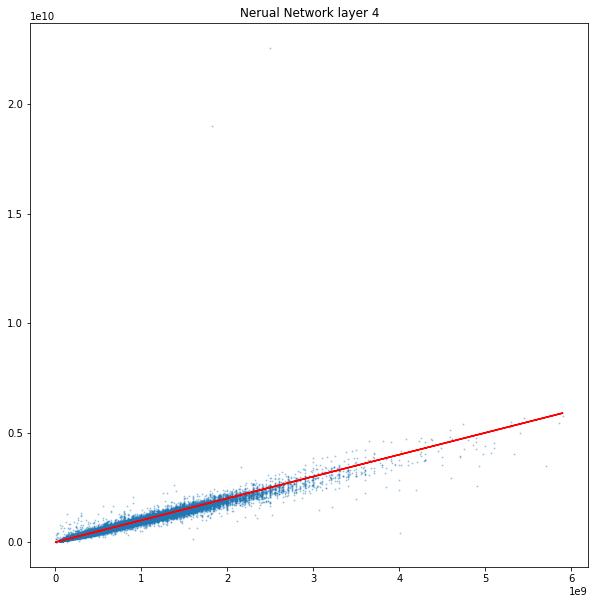

In [33]:
y_pred_nn_4 = dnn_layer_4.predict(X_test)
print('The accuracy of the Nerual Network layer 4 is', r2_score(np.exp2(y_test),np.exp2(y_pred_nn_4)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_nn_4))**0.5)

fig = plt.figure(figsize=(10,10))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_nn_4), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('Nerual Network layer 4')
plt.show()